# Information Retrieval: Programming Assignment \#2

### Sheetal Parikh
EN.605.744.81<br>
September 20, 2021
***
***

In [1]:
#imports for notebook
import sys
import re
import nltk
import os
import string
import struct
import numpy as np
import pandas as pd
import re
import math
import argparse

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
#from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter, namedtuple
#nltk.download('wordnet')

# change the current directory 
# to specified directory 
os.chdir(r"C:\Users\Sheetal\Documents\Sheetal\datasets") 

#checking current directory
#print(os.getcwd() + "\n")

#direct path to headlines file
filepath = '/Users/Sheetal/Documents/Sheetal/datasets/headlines.txt'

### Creating Postings List and Dictionary

The headlines text file was preprocessed by having the html tags removed, removing punctuation, applying a stemmmer and removing stop words.  The posting list will be a dictionary that contains the docid and frequency of the word in the document.  The dictionary will be a dictionary that lists the number of documents the term occurs in and the total frequency of the term.  The dictionary and will be created in in the fuction that saves the binary postings list file to disk.  The posting list and dictionary (dictionary objects) will be restructured into the Postings and Words namedtuples to format the data in a more organized way. In the previous assignment I had used a lemmatizer when preprocessing the data.  I decided to use a stemmer as it processed the data faster.  I didn't implement both a lemmatizer and stemmer becauase I thought it would limit the vocabulary.

In [2]:
#using named tuples to store information in a more organized way
#the Posting tuple will store the docid and the frequency of a word in the specific document
#the Words tuple will store the # of documents that contain the word and the total frequency of the word in the corpus

Postings = namedtuple("Posting", ["doc_id", "word_freq"])
Words = namedtuple("Word", ["total_docs", "offset"])

In [3]:
#importing list of stop words from nltk
stop_words = stopwords.words('english')

#the PortersStemmer from nlkt will be used to stem the words in the corpus
stemmer= PorterStemmer()

In [4]:
#preprocessing the text
def preprocess(text):
    text = re.sub("[{}]".format(string.punctuation), " ", text)
    text = text.split()
    text = [stemmer.stem(i) for i in text]
    text = [i for i in text if not i in stop_words]

    return text

In [5]:
#https://stackoverflow.com/questions/36108621/get-all-html-tags-with-beautiful-soup
#https://stackoverflow.com/questions/8933863/how-to-find-tags-with-only-certain-attributes-beautifulsoup

#function to create postings list

#filepath = direct path to file
def get_postings_list(filepath):
    
    #creating postings list dictionary object
    postings_list = {}
    
    #using BeautifulSoup to parse the headlines txt file
    content = BeautifulSoup(open(filepath), "html.parser")

    #removing html tags, preprocessing text and saving docids and counts of terms
    for i, html_tag in enumerate(content.find_all('p')):
        html_tag.attrs['id']
        
        #preprocessing
        text = preprocess(html_tag.text)
        vocab = Counter(text)

        #adding terms 
        for term, word_freq in vocab.items():
            if not term in postings_list:
                postings_list[term] = []

            postings_list[term].append(Postings(int(html_tag.attrs['id']), word_freq))

    return postings_list

In [6]:
#function to save binary postings list to disk and create dictionary

def postings_to_disk(postings_list, file_output='postings_list.txt'):
    
    #creating corpus dictionary object
    dictionary = {}

    #initial offset
    offset_0 = 0
    
    #writing to file
    with open(file_output, 'wb') as file_toDisk:
        for term in sorted(postings_list):
            
            #offset = total documents containing term * 4 bytes
            total_docs = len(postings_list[term])
            offset = offset_0 * 4

            dictionary[term] = Words(total_docs, offset)
            offset_0 += total_docs
            
            #writing output at binary 4 byte unsigned ; most significant byte stored first
            for posting in sorted(postings_list[term], key=lambda i: i.doc_id):
                file_toDisk.write(posting.doc_id.to_bytes(4, byteorder='big'))
                file_toDisk.write(posting.word_freq.to_bytes(4, byteorder='big'))

    return dictionary

In [7]:
#function to write the dictionary to a file on disk

def dictionary_to_disk(dictionary, file_output="dictionary.txt"):
    with open(file_output, "w") as file_toDisk2:
        for term in sorted(dictionary):
            t = dictionary[term]
            file_toDisk2.write("{} {} {}\n".format(term, t.total_docs, t.offset))

In [8]:
#creating postings list
postings_list = get_postings_list(filepath)

In [9]:
#saving binary postings list to disk as well as creating dictionary
dictionary = postings_to_disk(postings_list)

In [10]:
#saving dictionary to a file on disk
dictionary_to_disk(dictionary)

In [11]:
#printing size of dictionary and postings list files
file_size_dictionary = os.path.getsize('dictionary.txt')
file_size_postings = os.path.getsize('postings_list.txt')
file_size_headlines = os.path.getsize('headlines.txt')
file_size_difference = file_size_headlines - (file_size_postings + file_size_dictionary)

print(f'The size of the dictionary file is: {file_size_dictionary} bytes')
print(f'The size of the postings list file is: {file_size_postings} bytes')
print(f'The size of the original headlines file is: {file_size_headlines} bytes')
print(f'The size of the entire index is {file_size_difference} bytes smaller than the original headlines file')

The size of the dictionary file is: 2294794 bytes
The size of the postings list file is: 29698712 bytes
The size of the original headlines file is: 39381610 bytes
The size of the entire index is 7388104 bytes smaller than the original headlines file


### Summary: Results and Testing

As can be seen above, the dictionary and postings list files combined are smaller than the original headlines text.  The postings list file takes up more space than the dictionary file.  
<br>
The total number of words in the preprocessed text as well as the vocabulary (unique words) are smaller than what I had determined in the first programming assignment.  This could be due to using a stemmer instead of a lemmatizer and removing stop words. The number of documents/paragraphs determined for this assignment were also lower than the first assignment.  I was expecting 500,000 documents however, I am getting 499,911 documents.  It may be possible that several documents had many stop words or common words, removing a few documents. Also, since the postings list contains unique words, the word frequency in each document is primarily 1.
<br>

For searching for the test terms in the index, I had to search only for the lowercase versions of each word.  The PortStemmer converted all the words to lowercase. The words college, hopkins and trondheim were not found.  The term brown occured in 1083 documents which was the most of any of the other words tested.
<br>

I took a screenshot of the printed posting list and dictionary and added it at the end of the notebook.  Keeping the posting list and dictionary displayed in the jupyter notebook was causing print to pdf to crash.

In [12]:
#viewing posting_list - please see screenshot at end of document
#postings_list

In [13]:
#viewing dictionary - please see screenshot at end of document
#dictionary

In [14]:
#General headlines.txt file stats
unique_words = len(postings_list.keys())
total_words = sum([Word.word_freq for posting in postings_list.values() for Word in posting])
total_documents = len(set([Word.doc_id for posting in postings_list.values() for Word in posting]))

print(f'Total Words: {total_words}')
print(f'Total Unique Words: {unique_words}')
print(f'Total Documents/Paragraphs: {total_documents}')

Total Words: 3765689
Total Unique Words: 120930
Total Documents/Paragraphs: 499911


In [15]:
#functions to print results of testing terms - catches error and returns message if the testing word is not found

def test_posting_list(term):
    try:
        test = postings_list[term]
    except KeyError:
        print("Word is not in the postings list")
    else:
        return test
    
def test_dictionary(term):
    try:
        test2 = dictionary[term]
    except KeyError:
        print("Word is not in the dictionary")
    else:
        return test2


#### Heidelberg

In [16]:
test_posting_list('heidelberg')

[Posting(doc_id=114330, word_freq=1),
 Posting(doc_id=135134, word_freq=1),
 Posting(doc_id=174781, word_freq=1),
 Posting(doc_id=221100, word_freq=1),
 Posting(doc_id=243838, word_freq=1),
 Posting(doc_id=285521, word_freq=1),
 Posting(doc_id=295687, word_freq=1),
 Posting(doc_id=452546, word_freq=1),
 Posting(doc_id=491140, word_freq=1),
 Posting(doc_id=491279, word_freq=1)]

In [17]:
test_dictionary('heidelberg')

Word(total_docs=10, offset=6718364)

#### Cesium

In [18]:
test_posting_list('cesium')

[Posting(doc_id=50020, word_freq=1),
 Posting(doc_id=280670, word_freq=1),
 Posting(doc_id=348144, word_freq=1),
 Posting(doc_id=391939, word_freq=1),
 Posting(doc_id=394780, word_freq=1)]

In [19]:
test_dictionary('cesium')

Word(total_docs=5, offset=3293152)

#### Trondheim

In [20]:
test_posting_list('trondheim')

Word is not in the postings list


In [21]:
test_dictionary('trondheim')

Word is not in the dictionary


#### Crustacean

In [22]:
test_posting_list('crustacean')

[Posting(doc_id=230748, word_freq=1),
 Posting(doc_id=234924, word_freq=1),
 Posting(doc_id=426410, word_freq=1)]

In [23]:
test_dictionary('crustacean')

Word(total_docs=3, offset=4184008)

#### Hopkins

In [24]:
test_dictionary('hopkins')

Word is not in the dictionary


#### Stanford

In [25]:
test_dictionary('stanford')

Word(total_docs=154, offset=12647660)

#### Brown

In [26]:
test_dictionary('brown')

Word(total_docs=1083, offset=2874332)

#### College

In [27]:
test_dictionary('college')

Word is not in the dictionary


#### Elon and Musk

In [28]:
#function to extract all docids that have a specific term from postings list
def extractIDs(lst):
    return [item[0] for item in lst]

#all docids containing elon
elon_id = extractIDs(postings_list['elon'])

#all docids containing musk
musk_id = extractIDs(postings_list['musk'])

In [29]:
# printing docids for documents that have both elon and musk by finding intersection of the elon and musk docid lists

commonIDs = [i for i in elon_id and musk_id if i in elon_id and musk_id]

print(f'The following {len(commonIDs)} docids contain both "elon" and "musk": ')
print(commonIDs)

The following 46 docids contain both "elon" and "musk": 
[3394, 16331, 19263, 21342, 29750, 44322, 45979, 52991, 57024, 57788, 84807, 98831, 115208, 122604, 127051, 128663, 131449, 131515, 146966, 159148, 186108, 194999, 197342, 239305, 240041, 245924, 249586, 274394, 283099, 297140, 303776, 305184, 306989, 341756, 342183, 354347, 369773, 383529, 399002, 399947, 420083, 431496, 431740, 449685, 456444, 482770]


##### Screenshot of Postings List and Dictionary
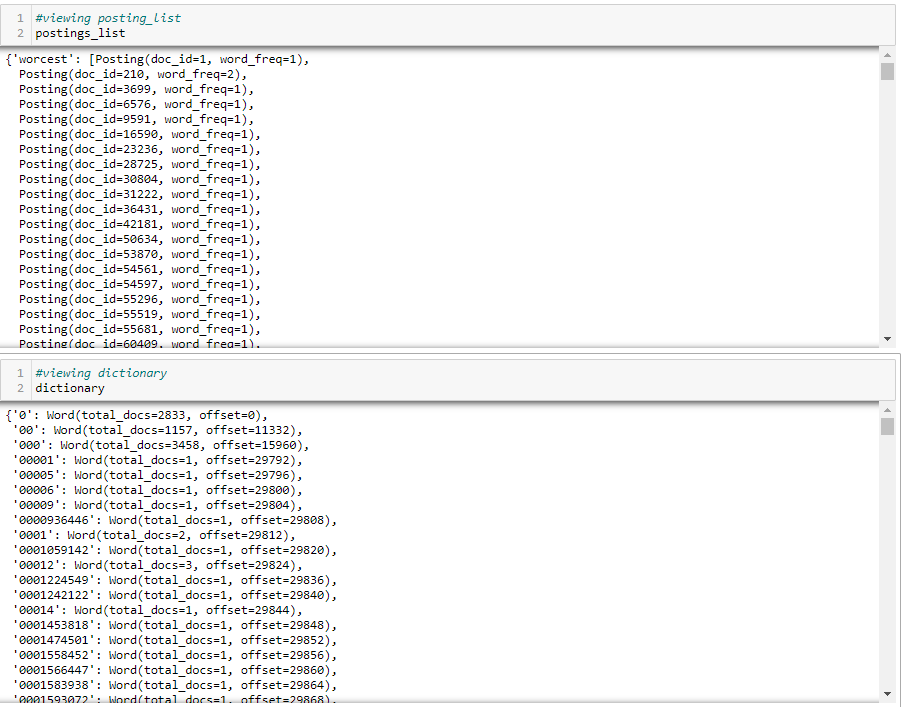

### References
https://stackoverflow.com/questions/36108621/get-all-html-tags-with-beautiful-soup

https://stackoverflow.com/questions/8933863/how-to-find-tags-with-only-certain-attributes-beautifulsoup

https://docs.python.org/3/library/collections.html

https://docs.python.org/3/library/string.html

https://www.geeksforgeeks.org/how-to-convert-int-to-bytes-in-python/

https://towardsdatascience.com/python-pro-tip-start-using-python-defaultdict-and-counter-in-place-of-dictionary-d1922513f747

https://realpython.com/python-namedtuple/

https://medium.com/analytics-vidhya/python-list-vs-tuple-vs-dictionary-4a48655c7934

https://stackoverflow.com/questions/8710456/reading-a-binary-file-with-python

https://www.geeksforgeeks.org/how-to-get-file-size-in-python/